In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from math import log, sqrt

In [2]:
class TTT():
    def __init__(self):
        self.board = np.zeros((3, 3));
        self.next = 1
    
    def actions(self):
        x, y = np.where(self.board == 0)
        return [(x[i], y[i]) for i in range(len(x))]
    
    def check_win(self):
        row_sums = np.sum(self.board, axis=0)
        col_sums = np.sum(self.board, axis=1)
        d1_sums = np.sum(self.board.diagonal())
        d2_sums = np.sum(np.fliplr(self.board).diagonal())
        
        row_check = np.any(row_sums == 3.)
        col_check = np.any(col_sums == 3.)
        d1_check = d1_sums == 3.
        d2_check = d2_sums == 3.
        
        if row_check or col_check or d1_check or d2_check:
            return 2
        
        row_check = np.any(row_sums == -3.)
        col_check = np.any(col_sums == -3.)
        d1_check = d1_sums == -3.
        d2_check = d2_sums == -3.
        
        if row_check or col_check or d1_check or d2_check:
            return -1
        
        if np.any(self.board == 0.):
            return 0
        
        return 1
    
    def gen_state(self, action):
        if self.board[action] != 0:
            raise Exception('Unavailable cell.')
        
        state = TTT()
        state.board = np.copy(self.board)
        
        state.board[action] = self.next
        state.next = -self.next
        
        return state
        
        
class MCTSNode():
    def __init__(self, state):
        self.state = state
        self.visits = 0
        self.value = state.check_win()
        self.terminal = self.value != 0
        self.children = []
        
    def generate_children(self):
        if self.children:
            raise Exception('Children already exist.')
        
        self.children = [(MCTSNode(self.state.gen_state(action)), action) for action in self.state.actions()]
        
    def ucb(self, parent_n):
        if self.terminal:
            return self.value
        
        if self.visits == 0:
            return None
        
        v = self.value / self.visits
        
        return v + 2 * sqrt(log(parent_n) / self.visits)
        
    
    def choose_children(self):
        if self.terminal:
            raise Exception('Leaf nodes have no children.')
            
        if not self.children:
            raise Exception('Children havent been generated.')
            
        if self.state.next == -1:
            return random.choice(self.children)
        
        ucb_list = [state.ucb(self.visits) for state, action in self.children]
        
        if None in ucb_list:
            idx = ucb_list.index(None)
        else:
            idx = np.argmax(ucb_list)
        
        return self.children[idx]
    
    def best_move(self):
        if self.terminal:
            raise Exception('Leaf nodes have no children.')
        
        if not self.children:
            raise Exception('Children havent been generated.')
        
        if self.state.next == -1:
            return random.choice(self.children)[0]
            
        ucb_list = [(state, state.ucb(self.visits)) for state, _ in self.children]
        ucb_list = [(state, ucb) for state, ucb in ucb_list if ucb != None]
        
        best_state, best_ucb = ucb_list[0]
        for state, ucb in ucb_list:
            if ucb > best_ucb:
                best_state = state
                best_ucb = ucb
        
        return best_state
        
    
def play(n_epochs=100000):
    root_state = TTT()
    root_node = MCTSNode(root_state)
    results = [0 for _ in range(n_epochs)]
    
    for i in range(n_epochs):
        node_hist = traverse(root_node)
        
        node_leaf = node_hist[-1]
        
        if not node_leaf.terminal:
            value = rollout(node_leaf)
            node_leaf.generate_children()
        else:
            value = node_leaf.value
            node_hist.pop()
        
        for node in node_hist:
            node.value += value
            node.visits += 1
        
        results[i] = value
    
    return root_node, results


def traverse(node):
    node_hist = [node]
    
    while node.children and not node.terminal:
        node = node.choose_children()[0]
        node_hist.append(node)
        
    return node_hist


def rollout(node):
    state = node.state
    value = state.check_win()
    
    while value == 0:
        actions = state.actions()
        a = random.choice(actions)
        
        state = state.gen_state(a)
        value = state.check_win()
    
    return value

In [3]:
root, results = play()

In [4]:
losses = np.cumsum((np.array(results) == -1))
ties = np.cumsum((np.array(results) == 1))
wins = np.cumsum(np.array(results) == 2)

losses.shape, ties.shape, wins.shape

((100000,), (100000,), (100000,))

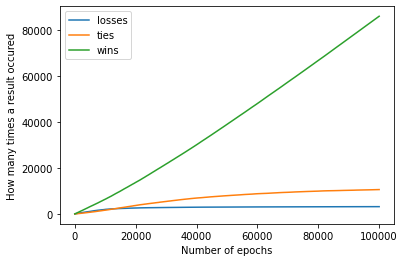

In [5]:
plt.plot(losses, label='losses')
plt.plot(ties, label='ties')
plt.plot(wins, label='wins')

plt.legend()
plt.ylabel('How many times a result occured')
plt.xlabel('Number of epochs')

plt.show()